# 回归

## 场景
回归，一般都是指 线性回归(linear regression)。线性回归意味着可以将输入项分别乘以一些常量，再将结果加起来得到输出。

线性回归假设特征和结果满足线性关系。其实线性关系的表达能力非常强大，每个特征对结果的影响强弱可以由前面的参数体现，而且每个特征变量可以首先映射到一个函数，然后再参与线性计算。这样就可以表达特征与结果之间的非线性关系

## 原理


### 1. 线性回归
在这种线性回归问题的矩阵表示中：
- $X$ 是一个 $m \times n$ 的矩阵，其中 $m$ 是样本数量，$n$ 是每个样本的特征数量。
- $x_i$ 表示第 $i$ 个样本的特征列向量，是一个 $n \times 1$ 的向量。

假定输入数据存放在矩阵 $X$ 中，而回归系数存放在向量 $w$ 中。那么对于给定的数据 $x_1$，预测结果将会通过 $Y = x_1^T w$ 给出。一个常用的方法就是找出使误差最小的 $w$。这里的误差是指预测 y 值和真实 y 值之间的差值，使用该误差的简单累加将使得正差值和负差值相互抵消，所以我们通常采用平方误差（实际就是我们通常所说的最小二乘法）。

平方误差可以写做（其实我们是使用这个函数作为 loss function）：

$$
MSE(w) = \frac{1}{m}\sum_{i=1}^m (y_i - x_i^T w)^2
$$

用矩阵表示则可以写做 $(Y - Xw)^T(Y - Xw)$。如果对 $w$ 求导，得到 $X^T(Y - Xw)$，令其等于零，解出 $w$ 如下（具体求导过程为：

$$
\hat{w} = (X^T X)^{-1} X^T Y
$$


In [13]:
import numpy as np
import matplotlib.pyplot as plt

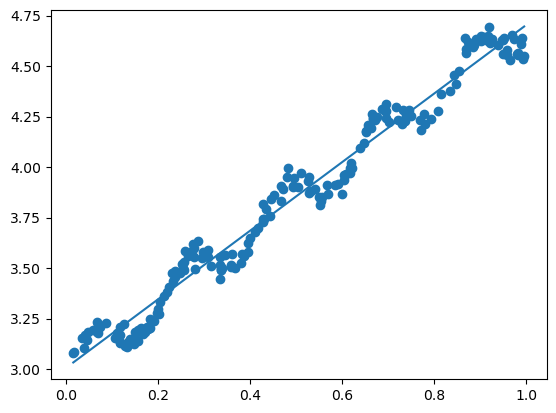

In [14]:
# 最简单的线性回归

def loadDataSet(fileName):
    dataMat = []
    with open(fileName) as f:
        for line in f:
            dataMat.append(line.strip().split('\t'))
    return np.array(dataMat, dtype=np.float64)

def standRegres(dataMat):
    X = dataMat[:, :-1]
    y = dataMat[:, -1]
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w


def plotRegression(dataMat, w):
    X = dataMat[:, :-1]
    y = dataMat[:, -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 1], y)
    xCopy = X.copy()
    xCopy.sort(axis=0)
    yHat = xCopy @ w
    ax.plot(xCopy[:, 1], yHat)
    plt.show()

def regression1():
    dataMat = loadDataSet('data.txt')
    w = standRegres(dataMat)
    plotRegression(dataMat, w)  

if __name__ == '__main__':
    regression1()

## 2. 局部加权线性回归

线性回归的一个问题是有可能出现欠拟合现象，因为它求的是具有最小均方差的无偏估计。显而易见，如果模型欠拟合将不能取得最好的预测效果。所以有些方法允许在估计中引入一些偏差，从而降低预测的均方误差。

局部加权线性回归（Locally Weighted Linear Regression，简称 LWLR 或者 LOESS）是一种非参数回归方法，它的目标是对数据进行局部拟合，而不是在整个数据集上寻找一个全局的线性关系。它适用于数据分布不均匀或者非线性关系明显的情况。以下是局部加权线性回归的原理和步骤：

### 1. 局部加权线性回归的核心思想

局部加权线性回归假设每一个样本点的预测都依赖于其附近的数据点，而与距离较远的点关系较小。为了实现这一点，LWLR 为每个数据点赋予一个权重，这个权重随着与目标点距离的增加而减小，从而对数据点进行“加权拟合”。

### 2. 权重的定义

对于每个待预测的样本 $x$，LWLR 定义了一个权重矩阵 $W$，该矩阵是一个对角矩阵，其中第 $i$ 个对角元素 $w_{ii}$ 表示第 $i$ 个样本点 $x_i$ 相对于目标点 $x$ 的权重：

$$
w_{ii} = \exp\left(-\frac{\|x - x_i\|^2}{2 \tau^2}\right)
$$

其中：
- $\|x - x_i\|$ 表示目标点 $x$ 和样本点 $x_i$ 的欧几里得距离。
- $\tau$ 是带宽参数（也称平滑参数），决定了权重的衰减速度。较小的 $\tau$ 值会导致较快的衰减，使得模型更加关注局部；较大的 $\tau$ 值会导致权重衰减较慢，使得模型关注更广泛的区域。

### 3. 计算回归系数

在 LWLR 中，我们希望在权重矩阵 $W$ 的加权下，最小化加权均方误差。给定一个目标点 $x$，LWLR 的损失函数（加权均方误差）为：

$$
\text{Loss} = (Y - Xw)^T W (Y - Xw)
$$

这里：
- $X$ 是特征矩阵，$Y$ 是目标值向量，$w$ 是待求解的回归系数。
- $W$ 是针对目标点 $x$ 的权重矩阵。

通过求导并令导数为零，可以得到 LWLR 的回归系数 $w$ 的解：

$$
w = (X^T W X)^{-1} X^T W Y
$$

这个公式与普通的线性回归类似，只是在 $X^T X$ 和 $X^T Y$ 前面加了一个加权矩阵 $W$。

### 4. 预测过程

为了对某个新的点 $x$ 进行预测，需要执行以下步骤：

1. 根据该点 $x$ 和训练数据的每个点 $x_i$ 之间的距离，计算权重矩阵 $W$。
2. 计算加权回归系数 $w$。
3. 预测值 $\hat{y}$ 就是 $x$ 与回归系数 $w$ 的内积，即 $\hat{y} = x^T w$。

### 5. 带宽参数 $\tau$ 的影响

带宽参数 $\tau$ 的选择非常重要，它控制了加权函数的宽度，进而决定了局部拟合的程度：
- **小的 $\tau$**：模型更加“局部”，会给离目标点较近的数据点更高的权重。这种情况可能适合数据较为复杂和非线性的情况，但可能导致过拟合。
- **大的 $\tau$**：模型更加“全局”，权重衰减较慢。这样的模型在更大的区域进行拟合，可能适合数据较为平滑的情况，但会导致欠拟合。

通常，$\tau$ 可以通过交叉验证来选择。

### 6. 局部加权线性回归的优缺点

#### 优点：
- **适应非线性数据**：由于每个点都是在局部范围内拟合的，LWLR 可以捕捉到非线性关系。
- **灵活**：LWLR 不需要预定义的模型结构，可以自动适应不同的样本区域。

#### 缺点：
- **计算复杂度高**：对于每一个待预测的样本，都要重新计算权重矩阵和回归系数，计算开销较大。
- **无法进行全局建模**：LWLR 不提供一个全局的模型方程，因此无法用于直接描述数据的整体结构。

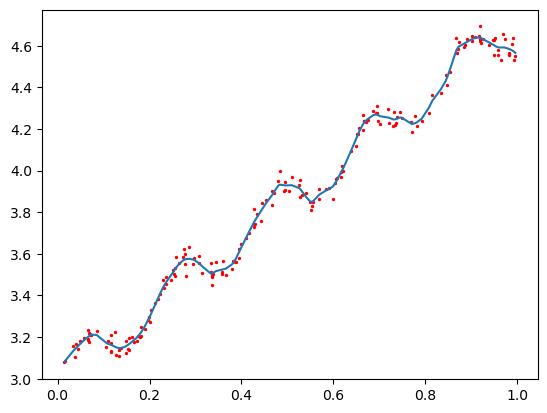

In [15]:
def lwlr(p, dataMat, tau=1.0):
    X = dataMat[:, :-1]
    y = dataMat[:, -1]
    m = X.shape[0]

    weights = np.exp(-np.sum((X - p) ** 2, axis=1) / (2 * tau ** 2))
    W = np.diag(weights)

    w = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y
    return w

def lwlrTest(testData, dataMat, tau=1.0):
    m = testData.shape[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = testData[i] @ lwlr(testData[i], dataMat, tau)
    return yHat

def regression2():
    dataMat = loadDataSet('data.txt')
    X = dataMat[:, :-1]
    y = dataMat[:, -1]
    yHat = lwlrTest(X, dataMat, tau=0.01)
    srtInd = X[:, 1].argsort(0)
    xSort = X[srtInd]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xSort[:, 1], yHat[srtInd])
    ax.scatter(X[:, 1], y, s=2, c='red')
    plt.show()

if __name__ == '__main__':
    regression2()